In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import cPickle as pkl

from flip_gradient import flip_gradient
from utils import *

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Process MNIST
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

# Compute pixel mean
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])


/Users/clayton/tfdev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


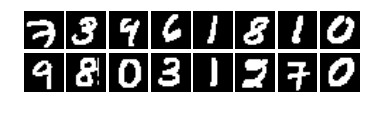

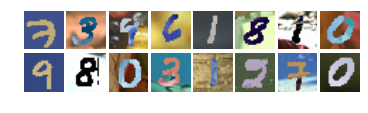

In [2]:
imshow_grid(mnist_train)
imshow_grid(mnistm_train)

In [3]:

batch_size = 128


class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self):
        self._build_model()
    
    def _build_model(self):
        
        self.X = tf.placeholder(tf.uint8, [None, 28, 28, 3])
        self.y = tf.placeholder(tf.float32, [None, 10])
        self.domain = tf.placeholder(tf.float32, [None, 2])
        self.l = tf.placeholder(tf.float32, [])
        self.train = tf.placeholder(tf.bool, [])
        
        X_input = (tf.cast(self.X, tf.float32) - pixel_mean) / 255.
        
        # CNN model for feature extraction
        with tf.variable_scope('feature_extractor'):

            W_conv0 = weight_variable([5, 5, 3, 32])
            b_conv0 = bias_variable([32])
            h_conv0 = tf.nn.relu(conv2d(X_input, W_conv0) + b_conv0)
            h_pool0 = max_pool_2x2(h_conv0)
            
            W_conv1 = weight_variable([5, 5, 32, 48])
            b_conv1 = bias_variable([48])
            h_conv1 = tf.nn.relu(conv2d(h_pool0, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            
            # The domain-invariant feature
            self.feature = tf.reshape(h_pool1, [-1, 7*7*48])
            
        # MLP for class prediction
        with tf.variable_scope('label_predictor'):
            
            all_features = lambda: self.feature
            source_features = lambda: tf.slice(self.feature, [0, 0], [batch_size / 2, -1])
            classify_feats = tf.cond(self.train, source_features, all_features)
            
            all_labels = lambda: self.y
            source_labels = lambda: tf.slice(self.y, [0, 0], [batch_size / 2, -1])
            self.classify_labels = tf.cond(self.train, source_labels, all_labels)
            
            W_fc0 = weight_variable([7 * 7 * 48, 100])
            b_fc0 = bias_variable([100])
            h_fc0 = tf.nn.relu(tf.matmul(classify_feats, W_fc0) + b_fc0)

            W_fc1 = weight_variable([100, 100])
            b_fc1 = bias_variable([100])
            h_fc1 = tf.nn.relu(tf.matmul(h_fc0, W_fc1) + b_fc1)

            W_fc2 = weight_variable([100, 10])
            b_fc2 = bias_variable([10])
            logits = tf.matmul(h_fc1, W_fc2) + b_fc2
            
            self.pred = tf.nn.softmax(logits)
            self.pred_loss = tf.nn.softmax_cross_entropy_with_logits(logits, self.classify_labels)

        # Small MLP for domain prediction with adversarial loss
        with tf.variable_scope('domain_predictor'):
            
            # Flip the gradient when backpropagating through this operation
            feat = flip_gradient(self.feature, self.l)
            
            d_W_fc0 = weight_variable([7 * 7 * 48, 100])
            d_b_fc0 = bias_variable([100])
            d_h_fc0 = tf.nn.relu(tf.matmul(self.feature, d_W_fc0) + d_b_fc0)
            
            d_W_fc1 = weight_variable([100, 2])
            d_b_fc1 = bias_variable([2])
            d_logits = tf.matmul(d_h_fc0, d_W_fc1) + d_b_fc1
            
            self.domain_pred = tf.nn.softmax(d_logits)
            self.domain_loss = tf.nn.softmax_cross_entropy_with_logits(d_logits, self.domain)


In [4]:

graph = tf.get_default_graph()
with graph.as_default():
    model = MNISTModel()
    
    learning_rate = tf.placeholder(tf.float32, [])
    
    pred_loss = tf.reduce_mean(model.pred_loss)
    domain_loss = tf.reduce_mean(model.domain_loss)
    total_loss = pred_loss + domain_loss

    dann_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(total_loss)
    
    # Evaluation
    correct_label_pred = tf.equal(tf.argmax(model.classify_labels, 1), tf.argmax(model.pred, 1))
    label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32))
    correct_domain_pred = tf.equal(tf.argmax(model.domain, 1), tf.argmax(model.domain_pred, 1))
    domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))
    
    

In [5]:
# Params
num_steps = 8600

def train_and_evaluate(training_mode, graph, model):

    with tf.Session(graph=graph) as sess:
        tf.initialize_all_variables().run()

        # Batch generators
        gen_source_only_batch = batch_generator(
            [mnist_train, mnist.train.labels], batch_size / 2)
        gen_target_only_batch = batch_generator(
            [mnistm_train, mnist.train.labels], batch_size / 2)

        domain_labels = np.vstack([np.tile([1., 0.], [batch_size / 2, 1]),
                                   np.tile([0., 1.], [batch_size / 2, 1])])

        # Training loop
        for i in range(num_steps):
            
            p = float(i) / num_steps
            l = 2. / (1. + np.exp(-10. * p)) - 1
            lr = 0.01 / (1. + 10 * p)**0.75

            # Training step
            if training_mode == 'dann':

                X0, y0 = gen_source_only_batch.next()
                X1, y1 = gen_target_only_batch.next()
                X = np.vstack([X0, X1])
                y = np.vstack([y0, y1])

                _, batch_loss, dloss, ploss, d_acc, p_acc = \
                    sess.run([dann_train_op, total_loss, domain_loss, pred_loss, domain_acc, label_acc],
                             feed_dict={model.X: X, model.y: y, model.domain: domain_labels,
                                        model.train: True, model.l: l, learning_rate: lr})

            elif training_mode == 'source':
                X, y = gen_source_only_batch.next()
                _, batch_loss = sess.run([regular_train_op, pred_loss],
                                     feed_dict={model.X: X, model.y: y})

            elif training_mode == 'target':
                X, y = gen_target_only_batch.next()
                _, batch_loss = sess.run([regular_train_op, pred_loss],
                                     feed_dict={model.X: X, model.y: y})

            if i % 50 == 0:
                print 'loss: %f  d_acc: %f  p_acc: %f  p: %f  l: %f  lr: %f' % (batch_loss, d_acc, p_acc, p, l, lr)

        source_acc = sess.run(label_acc,
                            feed_dict={model.X: mnist_test, model.y: mnist.test.labels, model.train: False})

        target_acc = sess.run(label_acc,
                            feed_dict={model.X: mnistm_test, model.y: mnist.test.labels, model.train: False})
        
        test_domain_acc = sess.run(domain_acc,
                            feed_dict={model.X: combined_test_imgs, model.domain: combined_test_domain})
        
        test_emb = sess.run(model.feature, feed_dict={model.X: combined_test_imgs})
        
    return source_acc, target_acc, test_domain_acc, test_emb


# print '\nSource only training'
# source_acc, target_acc, _, source_only_emb = train_and_evaluate('source', graph, model)
# print 'Source (MNIST) accuracy:', source_acc
# print 'Target (MNIST-M) accuracy:', target_acc

print '\nDomain adaptation training'
source_acc, target_acc, domain_acc, dann_emb = train_and_evaluate('dann', graph, model)
print 'Source (MNIST) accuracy:', source_acc
print 'Target (MNIST-M) accuracy:', target_acc
print 'Domain accuracy:', domain_acc


Domain adaptation training
loss: 5.122095  d_acc: 0.500000  p_acc: 0.156250  p: 0.000000  l: 0.000000  lr: 0.010000
loss: 0.552071  d_acc: 0.945312  p_acc: 0.875000  p: 0.005814  l: 0.029062  lr: 0.009585
loss: 0.302330  d_acc: 1.000000  p_acc: 0.921875  p: 0.011628  l: 0.058074  lr: 0.009208
loss: 0.405507  d_acc: 0.992188  p_acc: 0.875000  p: 0.017442  l: 0.086989  lr: 0.008864
loss: 0.156781  d_acc: 0.984375  p_acc: 0.968750  p: 0.023256  l: 0.115758  lr: 0.008549
loss: 0.275199  d_acc: 0.992188  p_acc: 0.937500  p: 0.029070  l: 0.144334  lr: 0.008258
loss: 0.092236  d_acc: 1.000000  p_acc: 0.984375  p: 0.034884  l: 0.172671  lr: 0.007990
loss: 0.075159  d_acc: 0.992188  p_acc: 0.984375  p: 0.040698  l: 0.200725  lr: 0.007741
loss: 0.126048  d_acc: 1.000000  p_acc: 0.968750  p: 0.046512  l: 0.228454  lr: 0.007509
loss: 0.116945  d_acc: 0.992188  p_acc: 0.953125  p: 0.052326  l: 0.255818  lr: 0.007293
loss: 0.218463  d_acc: 1.000000  p_acc: 0.953125  p: 0.058140  l: 0.282777  lr: 0.